# LCO: Wang data

In [1]:
import galpynostatic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Cargamos los datos para el LCO recubierto con Ti$_2$ y las $C_{rates}$ utilizadas

In [2]:
C_rates = [0.5, 1, 2, 5, 10, 20]

In [3]:
dataframes = [pd.read_csv(f"data/wang/{crate}C.csv", header=None) for crate in C_rates]

Ploteamos las curvas para verlas, con el potencial de equilibrio y el de corte correspondientes.

In [4]:
eq_pot = 3.9  # este valor es mencionado en el trabajo
vcut = 0.15

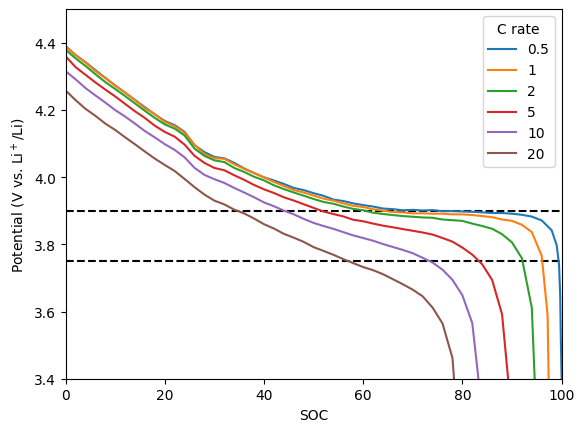

In [11]:
fig, ax = plt.subplots()

ax.axhline(y=eq_pot, color="k", linestyle="--")
ax.axhline(y=eq_pot - vcut, color="k", linestyle="--")
for crate, df in zip(C_rates, dataframes):
    ax.plot(df[0], df[1], label=f"{crate}")
    
ax.set_xlim((0, 100))
ax.set_ylim((3.4, 4.5))
ax.set_xlabel(r"SOC")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="C rate")
plt.show()

Podemos usar la herramienta desarrollada para obtener las capacidades de descarga

In [12]:
C_rates = np.asarray(C_rates).reshape(-1, 1)
xmaxs = galpynostatic.preprocessing.get_discharge_capacities(dataframes, eq_pot)
xmaxs

array([99.417946, 96.75683 , 93.01233 , 83.45085 , 73.432816, 56.96607 ],
      dtype=float32)

Podemos normalizar estas corrientes por algún valor que deseemos, en este caso 100 para tener entre 0 y 1

In [13]:
xmaxs = xmaxs / 100
xmaxs

array([0.9941795 , 0.9675683 , 0.93012327, 0.83450854, 0.73432815,
       0.56966066], dtype=float32)

Y visualizar los datos que vamos a usar para ajustar

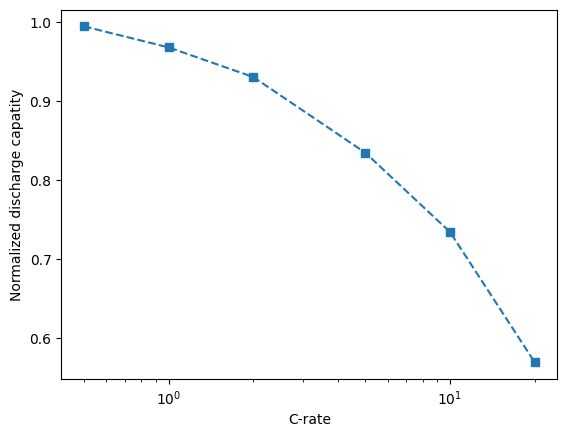

In [14]:
plt.plot(C_rates, xmaxs, marker="s", ls="--")

plt.xlabel("C-rate")
plt.ylabel("Normalized discharge capatity")
plt.xscale("log")
plt.show()

En el trabajo se menciona que los tamaños de particulas están distribuidos entre $5-40\mu m$, pero que para medir toman las de 20 $\mu m$

In [16]:
d = 0.002

Cargamos los datos de la superficie para la geometría esférica

In [17]:
dataset = galpynostatic.datasets.load_spherical()

Y fiteamos sobre la misma

In [18]:
greg = galpynostatic.model.GalvanostaticRegressor(dataset, d, 3)

greg.fit(C_rates, xmaxs)

Y el valor extrapolado para el coeficiente de difusión es de

In [19]:
greg.dcoeff_

5.336699231206302e-09

Mientras que el coeficiente de difusión reportado en este trabajo, para este ratio Li/Ti, es de $5.12\times10^{-12}$

mientras que el de k0 es

In [20]:
greg.k0_

1e-05

con un error cuadrático medio para el modelo de

In [21]:
greg.mse_

0.0007837800963273451

Podemos estimar el valor óptimo para la longuitud caracteristica de la nanoparticula, es decir el tamaño para obtener un 80% en 5 minutos

In [22]:
greg.t_minutes_lenght()

16.256610323281983

Ploteamos los datos versus las predicciones

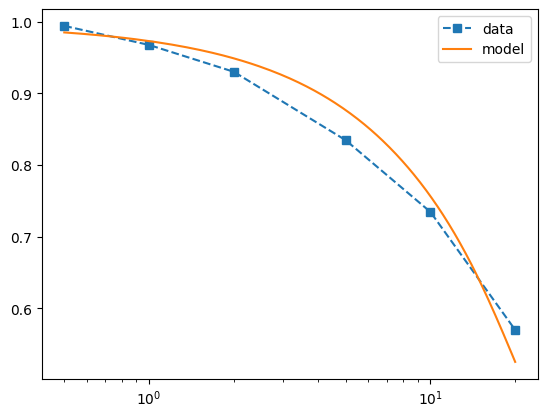

In [24]:
greg.plot_vs_data(C_rates, xmaxs)
plt.xscale("log")
plt.legend()
plt.show()

Por último, podemos observar la región del mapa en la que se encuentran estos resultados

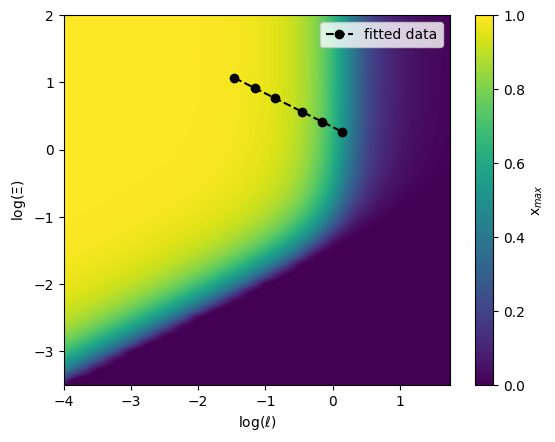

In [25]:
greg.plot_in_surface(C_rates)
plt.legend()
plt.show()